In [88]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timer Frequency

Reference Manual 0365

pg 555

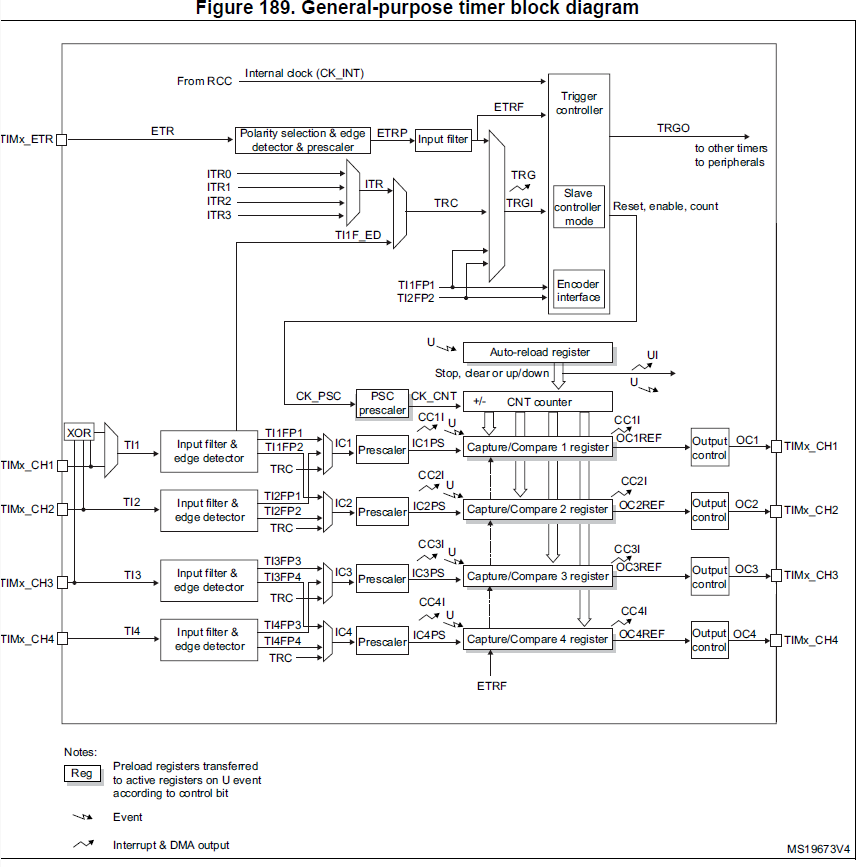

pg 119

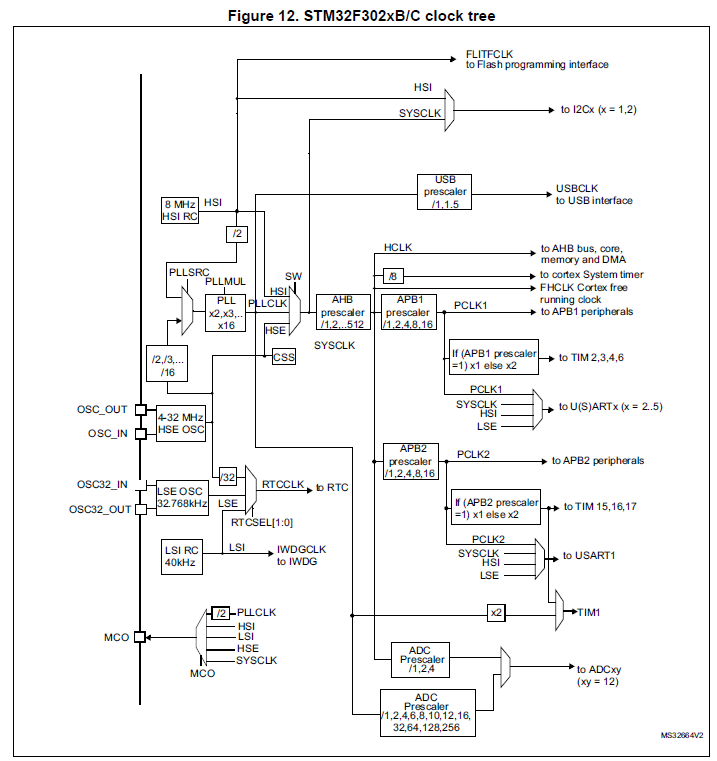

- `CK_PSC` = Clock input to timer before presaler
- `CK_CNT` = Clock Counter after prescaler

$$
\begin{align}
T_{\text{CK\_CNT}} &= (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
\frac{1}{f_{\text{CK\_CNT}}} &= \frac{\text{PSC} + 1}{f_{\text{CK\_PSC}}} \\
f_{\text{CK\_CNT}} &= \frac{f_{\text{CK\_PSC}}}{\text{PSC} + 1} \\
\end{align}
$$

We are using the internal clock `CK_INT` in our application, so we have

$$
\begin{align}
T_{\text{CK\_PSC}} &= T_{\text{CK\_INT}} \\
f_{\text{CK\_PSC}} &= f_{\text{CK\_INT}} \\
\end{align}
$$

To convert between counts, $n$, and the duration it takes for the counter to reach that value $T_n$, we have

$$
\begin{align}
T_n &= n T_{\text{CK\_CNT}} \\
T_n &= n (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
T_n &= \frac{n (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
\end{align}
$$

and a desired $n$ value may be found using

$$
\begin{align}
T_n f_{\text{CK\_PSC}} &= n (\text{PSC} + 1) \\
n &= \frac{T_n f_{\text{CK\_PSC}}}{\text{PSC} + 1} \\
\end{align}
$$

In [89]:
def calc_Tn_from_counts(n, PSC, f_CK_PSC):
    return (n * (PSC + 1)) / f_CK_PSC

def calc_counts_from_Tn(Tn, PSC, f_CK_PSC):
    return round((Tn * f_CK_PSC) / (PSC + 1))

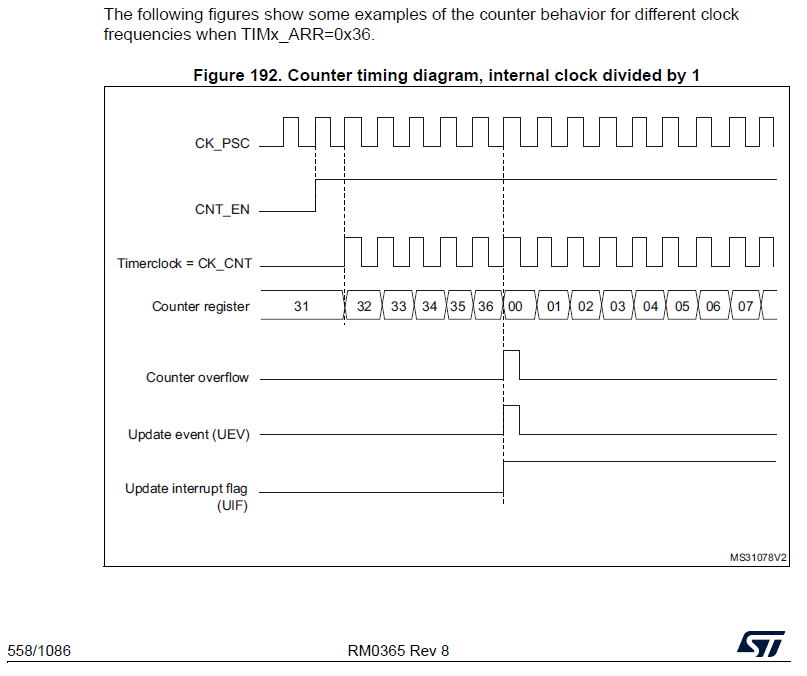

The timer resets and issues an update event `UEV` when the counter counts up to and includes `ARR` after counting up from zero. In this case, $n=\text{ARR} + 1$ and so

$$
\begin{align}
T_{\text{UEV}} &= \frac{(\text{ARR} + 1) (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
\end{align}
$$

The Timer reset frequency can then be found

$$
\begin{align}
\frac{1}{f_{\text{UEV}}} &= \frac{(\text{ARR} + 1) (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
f_{\text{UEV}} &= \frac{f_{\text{CK\_PSC}}}{(\text{ARR} + 1) (\text{PSC} + 1)} \\
\end{align}
$$

In the reverse case if target $f_{\text{UEV}}$, `CK_PSC`, and `PSC` is known, we can find associated `ARR`

$$
\begin{align}
\frac{f_{\text{UEV}} (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} &= \frac{1}{(\text{ARR} + 1) } \\
\text{ARR} + 1 &= \frac{f_{\text{CK\_PSC}}}{f_{\text{UEV}} (\text{PSC} + 1)} \\
\text{ARR} &= \frac{f_{\text{CK\_PSC}}}{f_{\text{UEV}} (\text{PSC} + 1)} - 1 \\
\end{align}
$$

In [90]:
def calc_T_UEV(ARR, PSC, f_CK_PSC):
    return calc_Tn_from_counts(n=ARR+1, PSC=PSC, f_CK_PSC=f_CK_PSC)

def calc_f_UEV(f_CK_PSC, PSC, ARR):
    return f_CK_PSC / ((ARR + 1) * (PSC + 1))

def calc_ARR(f_UEV, f_CK_PSC, PSC):
    return round((f_CK_PSC / (f_UEV * (PSC + 1))) - 1)

In [91]:
f_CK_PSC = Q(64e6, 'Hz')
PSC = 0

for f_UEV_ideal in Q([20e3, 80e3, 100e3], 'Hz'):
    ARR = calc_ARR(f_UEV=f_UEV_ideal, f_CK_PSC=f_CK_PSC, PSC=PSC)
    f_UEV = calc_f_UEV(f_CK_PSC=f_CK_PSC, PSC=PSC, ARR=ARR)
    print(f"When ARR set to {ARR.magnitude:.0f}, frequency is {f_UEV:.0f}")

When ARR set to 3199, frequency is 20000 hertz
When ARR set to 799, frequency is 80000 hertz
When ARR set to 639, frequency is 100000 hertz


In [92]:
ARR = 1000
f_UEV = calc_f_UEV(f_CK_PSC=f_CK_PSC, PSC=PSC, ARR=ARR)
print(f"When ARR is {ARR}, f_UEV is {f_UEV:.0f}")

When ARR is 1000, f_UEV is 63936 hertz


# Addressable LED Pulse Study

In PWM mode, we are concerned with the duration of the output pulse before reaching the `CCR` value.

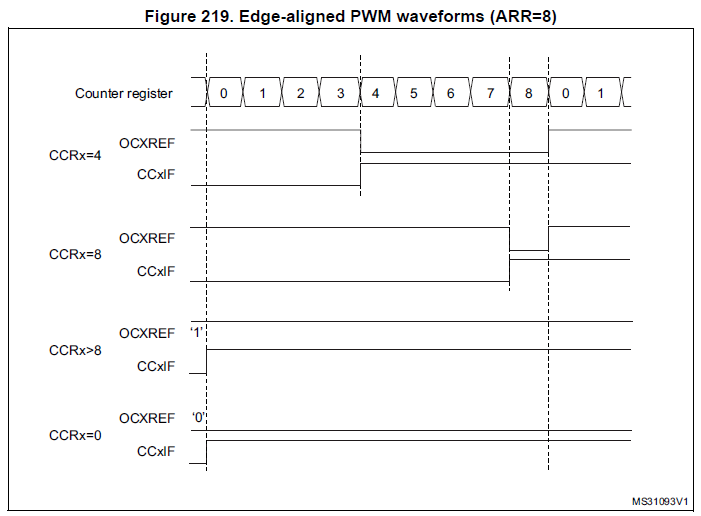

Unlike the `ARR` and `PSC` register usage, the output changes sign *at the start* of when the counter reaches the `CCR` value.  In this case, a pulse with duration $T_{\text{PULSE}}$ would then change state when $n = \text{CCR}$ is reached.

$$
\begin{align}
T_{\text{PULSE}} &= \text{CCR} T_{\text{CK\_CNT}} \\
T_{\text{PULSE}} &= \text{CCR} (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
T_{\text{PULSE}} &= \frac{\text{CCR} (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
\end{align}
$$

Similarly, the `CCR` value for a desired $T_{\text{PULSE}}$ can be found

$$
\begin{align}
\text{CCR} &= \frac{T_{\text{PULSE}}}{(\text{PSC} + 1) T_{\text{CK\_PSC}}} \\
\text{CCR} &= \frac{T_{\text{PULSE}} f_{\text{CK\_PSC}}}{(\text{PSC} + 1)} \\
\end{align}
$$

In [93]:
for T_PULSE_ideal in Q([300, 350, 700, 750], 'nsec'):
    CCR = round(calc_counts_from_Tn(T_PULSE_ideal, PSC, f_CK_PSC).to('')) # need to re-round with dimension change
    T_PULSE = calc_Tn_from_counts(CCR, PSC, f_CK_PSC)
    print(f"When CCR is {CCR.magnitude:.0f}, T_PULSE is {T_PULSE.to('nsec'):.3f} (closest to {T_PULSE_ideal.to('nsec'):.3f})")

When CCR is 19, T_PULSE is 296.875 nanosecond (closest to 300.000 nanosecond)
When CCR is 22, T_PULSE is 343.750 nanosecond (closest to 350.000 nanosecond)
When CCR is 45, T_PULSE is 703.125 nanosecond (closest to 700.000 nanosecond)
When CCR is 48, T_PULSE is 750.000 nanosecond (closest to 750.000 nanosecond)


# Addressable LED Write Duration

Adafruit neopixels generally use either of two options

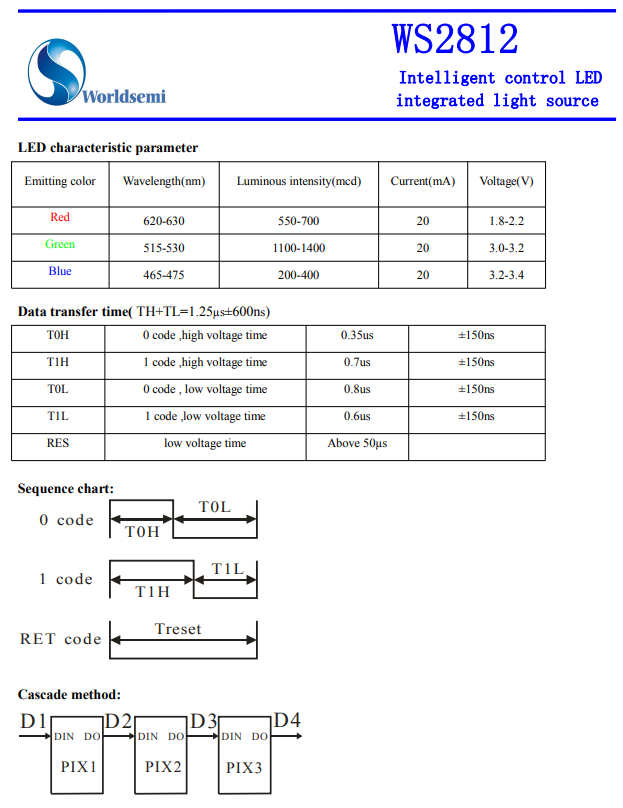

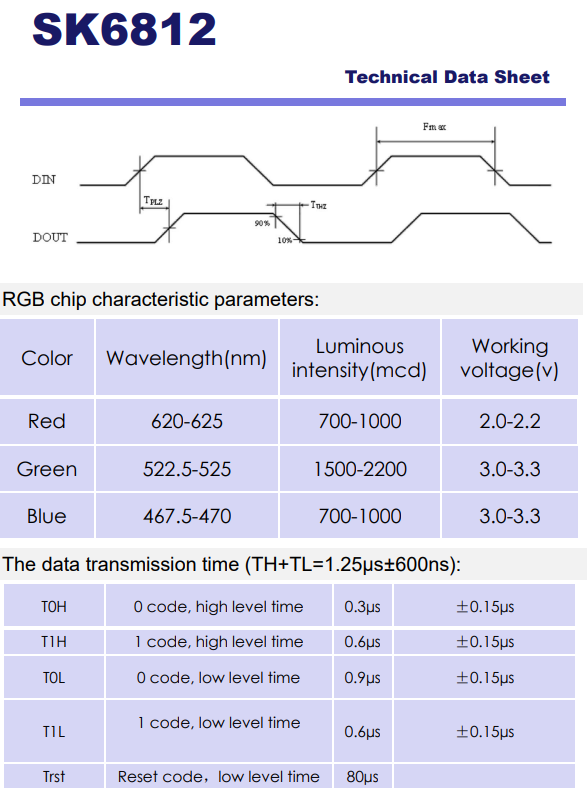

In [94]:
f_UEV_ideal = Q(80e3, 'Hz')
ARR = calc_ARR(f_UEV=f_UEV_ideal, f_CK_PSC=f_CK_PSC, PSC=PSC)
f_UEV = calc_f_UEV(f_CK_PSC=f_CK_PSC, PSC=PSC, ARR=ARR)
print(f"When ARR set to {ARR.magnitude:.0f}, frequency is {f_UEV:.0f}")

When ARR set to 799, frequency is 80000 hertz


In [95]:
n_channels = 3
T_write_single = n_channels * 8 * calc_T_UEV(ARR=ARR, PSC=PSC, f_CK_PSC=f_CK_PSC)
print(f"Time to write single LED is {T_write_single.to('usec'):.3f}")

for n_LEDs in [10, 100, 200]:
    T_write_n_LEDs = n_LEDs * T_write_single
    print(f"Time to write {n_LEDs} LEDs is {T_write_n_LEDs.to('msec'):.3f} (Maximum update frequency is {1/T_write_n_LEDs:.0f})")

Time to write single LED is 300.000 microsecond
Time to write 10 LEDs is 3.000 millisecond (Maximum update frequency is 333 hertz)
Time to write 100 LEDs is 30.000 millisecond (Maximum update frequency is 33 hertz)
Time to write 200 LEDs is 60.000 millisecond (Maximum update frequency is 17 hertz)


Plan to put addressable LEDs in parallel channels